In [1]:
import torch
import torch.nn as nn
import torch

In [2]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary
import random
from utils.read_dataset import read_dataset
import numpy as np
import copy

In [3]:
from config import num_classes, model_name, model_path, lr_milestones, lr_decay_rate, input_size, \
    root, end_epoch, save_interval, init_lr, batch_size, CUDA_VISIBLE_DEVICES, weight_decay, \
    proposalN, set, channels

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
torch.cuda.is_available()

True

In [6]:
print(torch. __version__)

1.14.0.dev20221118+cu116


In [7]:
# import pandas as pd

In [8]:
# pop=r"C:\Users\Admin\Dropbox\PC\Documents\FGVC_MSFM\MMAL-Net\datasets\multiclass_path\train_positive.txt"
# nop=r"C:\Users\Admin\Dropbox\PC\Documents\FGVC_MSFM\MMAL-Net\datasets\multiclass_path\train_negative.txt"

In [9]:
# pdf=pd.read_table(nop)

In [10]:
# pdf=pdf.sample(frac=1)

In [11]:
# pdf.to_csv(nop, index=False)



In [12]:
import torch
import torch.nn as nn
from pytorch_pretrained_vit import ViT

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, return_cam=True, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.num_classes=num_classes
        self.base_width = width_per_group
        self.return_cam=return_cam
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        # self.conv2 = nn.Conv2d(in_channels=2048, out_channels=2048, kernel_size=4, stride=1,bias=False)
        # self.conv3 = nn.Conv2d(in_channels=2048, out_channels=201, kernel_size=1, stride=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512 * block.expansion, self.num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def forward(self, x):
#         x=ViT('B_16')(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        conv5_b = self.layer4[:2](x)
        x = self.layer4[2](conv5_b)

        fm = x
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
       
        embeeding = x
        
        return fm, embeeding


def _resnet(arch, block, layers, pretrained, pth_path, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = torch.load(pth_path)
        model.load_state_dict(state_dict)
    return model


def resnet18(pth_path, pretrained=False, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, pth_path,
                   **kwargs)



def resnet34(pth_path, pretrained=False, **kwargs):
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, pth_path,
                   **kwargs)



def resnet50(pth_path, pretrained=False, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3],pretrained, pth_path,
                   **kwargs)



def resnet101(pth_path, pretrained=False, **kwargs):
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, pth_path,
                   **kwargs)



def resnet152(pth_path, pretrained=False, **kwargs):
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, pth_path,
                   **kwargs)



def resnext50_32x4d(pth_path, pretrained=False, **kwargs):
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, pth_path, **kwargs)



def resnext101_32x8d(pth_path, pretrained=False, **kwargs):
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, pth_path, **kwargs)



def wide_resnet50_2(pth_path, pretrained=False, **kwargs):
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, pth_path, **kwargs)



def wide_resnet101_2(pth_path, pretrained=False, **kwargs):
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, pth_path, **kwargs)


In [72]:
import torch
from skimage import measure
x_test=torch.rand(5, 3, 448, 448)
pretrain_path_B='./models/pretrained/resnet50-19c8e357.pth'

In [73]:
fms=torch.rand(1, 2, 14, 14)
fm1=torch.rand(1, 2048, 14, 14)

In [77]:
mod=resnet50(pretrain_path_B, pretrained=False)

In [78]:
y_test=mod(x_test)

In [79]:
y_test[0].shape

torch.Size([5, 2048, 14, 14])

In [17]:
y_test_1=mod(x_test)

In [18]:
# torch.sigmoid(y_test_1[0])

tensor([[[[0.7463, 0.7228, 0.5000,  ..., 0.7318, 0.7303, 0.6049],
          [0.5000, 0.5839, 0.7030,  ..., 0.5488, 0.6210, 0.6016],
          [0.6236, 0.5573, 0.6320,  ..., 0.6255, 0.7858, 0.7633],
          ...,
          [0.8164, 0.5364, 0.6819,  ..., 0.5000, 0.5000, 0.5000],
          [0.6418, 0.5062, 0.5000,  ..., 0.5455, 0.5000, 0.5000],
          [0.5000, 0.5454, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],

         [[0.6182, 0.8878, 0.7411,  ..., 0.8034, 0.5009, 0.5379],
          [0.5000, 0.7164, 0.5000,  ..., 0.7383, 0.5000, 0.5981],
          [0.6680, 0.5000, 0.5000,  ..., 0.7756, 0.5381, 0.5000],
          ...,
          [0.7515, 0.5029, 0.5000,  ..., 0.6367, 0.9076, 0.8502],
          [0.6324, 0.5880, 0.7536,  ..., 0.5000, 0.9192, 0.7670],
          [0.6815, 0.7422, 0.7364,  ..., 0.5000, 0.5000, 0.6338]],

         [[0.7204, 0.9289, 0.7502,  ..., 0.5000, 0.5000, 0.5341],
          [0.5000, 0.6913, 0.7531,  ..., 0.5000, 0.5000, 0.5000],
          [0.6339, 0.5245, 0.5000,  ..., 0

In [19]:
# y_test

(tensor([[[[1.0789e+00, 9.5819e-01, 0.0000e+00,  ..., 1.0039e+00,
            9.9636e-01, 4.2575e-01],
           [0.0000e+00, 3.3897e-01, 8.6179e-01,  ..., 1.9601e-01,
            4.9368e-01, 4.1210e-01],
           [5.0474e-01, 2.3007e-01, 5.4100e-01,  ..., 5.1295e-01,
            1.2996e+00, 1.1708e+00],
           ...,
           [1.4920e+00, 1.4587e-01, 7.6246e-01,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [5.8314e-01, 2.4759e-02, 0.0000e+00,  ..., 1.8261e-01,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 1.8196e-01, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]],
 
          [[4.8192e-01, 2.0684e+00, 1.0516e+00,  ..., 1.4078e+00,
            3.4850e-03, 1.5172e-01],
           [0.0000e+00, 9.2685e-01, 0.0000e+00,  ..., 1.0370e+00,
            0.0000e+00, 3.9763e-01],
           [6.9927e-01, 0.0000e+00, 0.0000e+00,  ..., 1.2401e+00,
            1.5281e-01, 0.0000e+00],
           ...,
           [1.1068e+00, 1.1679e-02, 0.

In [20]:
# X, Y=A[0][0][:, 0], A[0][0][:, 1]

In [21]:
A = torch.sigmoid(torch.sum(fms, dim=1, keepdim=True))
a = torch.mean(A, dim=[2, 3], keepdim=True)
M = (A > a).float()
A1 = torch.sigmoid(torch.sum(fm1, dim=1, keepdim=True))
a1 = torch.mean(A1, dim=[2, 3], keepdim=True)
M1 = (A1 > a1).float()
coordinates = []
for i, m in enumerate(M):
    mask_np = m.cpu().numpy().reshape(14, 14)
    component_labels = measure.label(mask_np, connectivity=1)

    properties = measure.regionprops(component_labels)
    areas = []
    for prop in properties:
        areas.append(prop.area)
    max_idx = areas.index(max(areas))


    intersection = ((component_labels==(max_idx+1)).astype(int) + (M1[i][0].cpu().numpy()==1).astype(int)) ==2
    prop = measure.regionprops(intersection.astype(int))
    if len(prop) == 0:
        bbox = [0, 0, 14, 14]
#             print('there is one img no intersection')
    else:
        bbox = prop[0].bbox
#         print("B box is",bbox)
    x_lefttop = bbox[0] * 32 - 1
    y_lefttop = bbox[1] * 32 - 1
    x_rightlow = bbox[2] * 32 - 1
    y_rightlow = bbox[3] * 32 - 1
    # for image
    if x_lefttop < 0:
        x_lefttop = 0
    if y_lefttop < 0:
        y_lefttop = 0
    coordinate = [x_lefttop, y_lefttop, x_rightlow, y_rightlow]
    coordinates.append(coordinate)

In [22]:
A.shape

torch.Size([1, 1, 14, 14])

In [23]:
torch.sigmoid(A).shape

torch.Size([1, 1, 14, 14])

In [24]:
# component_labels

In [25]:
# component_labels

In [26]:
# coordinates

In [27]:
# coordinates

In [28]:
import torch
from skimage import measure
def CFM2(fms):
    A = torch.sum(fms, dim=1, keepdim=True)
    a = torch.mean(A, dim=[2, 3], keepdim=True)
    M = (A > a).float()

    coordinates = []
    for i, m in enumerate(M):
        mask_np = m.cpu().numpy().reshape(14, 14)
        component_labels = measure.label(mask_np)

        properties = measure.regionprops(component_labels)
        areas = []
        for prop in properties:
            areas.append(prop.area)
        
        max_idx = areas.index(max(areas))


        intersection = ((component_labels==(max_idx+1)).astype(int))==1
        
        prop = measure.regionprops(intersection.astype(int))
          
        if len(prop) == 0:
            bbox = [0, 0, 14, 14]
            print('there is one img no intersection')
        else:
            
            bbox = prop[0].bbox
            print(bbox)
#         print("B box is",bbox)
        x_lefttop = bbox[0] * 32 - 1
        y_lefttop = bbox[1] * 32 - 1
        x_rightlow = bbox[2] * 32 - 1
        y_rightlow = bbox[3] * 32 - 1
        # for image
        if x_lefttop < 0:
            x_lefttop = 0
        if y_lefttop < 0:
            y_lefttop = 0
        coordinate = [x_lefttop, y_lefttop, x_rightlow, y_rightlow]
        coordinates.append(coordinate)
    return coordinates

In [29]:
import torch
from skimage import measure
def AOLM(fms, fm1):
    A = torch.sum(fms, dim=1, keepdim=True)
    a = torch.mean(A, dim=[2, 3], keepdim=True)
    M = (A > a).float()

    A1 = torch.sum(fm1, dim=1, keepdim=True)
    a1 = torch.mean(A1, dim=[2, 3], keepdim=True)
    M1 = (A1 > a1).float()


    coordinates = []
    for i, m in enumerate(M):
        mask_np = m.cpu().numpy().reshape(14, 14)
        component_labels = measure.label(mask_np, connectivity=2)

        properties = measure.regionprops(component_labels)
        areas = []
        for prop in properties:
            areas.append(prop.area)
#         print(areas)
        max_idx = areas.index(max(areas))


        intersection = ((component_labels==(max_idx+1)).astype(int) + (M1[i][0].cpu().numpy()==1).astype(int)) ==2
        prop = measure.regionprops(intersection.astype(int))
        if len(prop) == 0:
            bbox = [0, 0, 14, 14]
#             print('there is one img no intersection')
        else:
            bbox = prop[0].bbox
#             print("B box is",bbox)
        x_lefttop = bbox[0] * 32 - 1
        y_lefttop = bbox[1] * 32 - 1
        x_rightlow = bbox[2] * 32 - 1
        y_rightlow = bbox[3] * 32 - 1
        # for image
        if x_lefttop < 0:
            x_lefttop = 0
        if y_lefttop < 0:
            y_lefttop = 0
        coordinate = [x_lefttop, y_lefttop, x_rightlow, y_rightlow]
        coordinates.append(coordinate)
    return coordinates

In [30]:
##################################
# segmentation function
##################################
def batch_segmentation(images, attention_map, mode='crop', theta=0.5, padding_ratio=0.1):
    batches, _, imgH, imgW = images.size()

    if mode == 'crop':
        crop_images = []
        for batch_index in range(batches):
            atten_map = attention_map[batch_index:batch_index + 1]
            if isinstance(theta, tuple):
                theta_c = random.uniform(*theta) * atten_map.max()
            else:
                theta_c = theta * atten_map.max()

            crop_mask = F.upsample_bilinear(atten_map, size=(imgH, imgW)) >= theta_c
            nonzero_indices = torch.nonzero(crop_mask[0, 0, ...])
            height_min = max(int(nonzero_indices[:, 0].min().item() - padding_ratio * imgH), 0)
            height_max = min(int(nonzero_indices[:, 0].max().item() + padding_ratio * imgH), imgH)
            width_min = max(int(nonzero_indices[:, 1].min().item() - padding_ratio * imgW), 0)
            width_max = min(int(nonzero_indices[:, 1].max().item() + padding_ratio * imgW), imgW)

            crop_images.append(
                F.upsample_bilinear(images[batch_index:batch_index + 1, :, height_min:height_max, width_min:width_max],
                                    size=(imgH, imgW)))
        crop_images = torch.cat(crop_images, dim=0)
        return crop_images

    elif mode == 'drop':
        drop_masks = []
        for batch_index in range(batches):
            atten_map = attention_map[batch_index:batch_index + 1]
            if isinstance(theta, tuple):
                theta_d = random.uniform(*theta) * atten_map.max()
            else:
                theta_d = theta * atten_map.max()
            msk=F.upsample_bilinear(atten_map, size=(imgH, imgW)) < theta_d
            q =msk.float()
            tense_tensor = torch.tensor(q, device='cuda')
            label=torch.where(tense_tensor==0.0, torch.tensor(2.0, device = 'cuda'), tense_tensor)
#             drop_masks.append(label)
            drop_masks.append(label2rgb(label, images[batch_index], kind = 'overlay'))
        drop_masks = torch.cat(drop_masks, dim=0).float()
#         label2rgb(astronaut_segments, image, kind = 'overlay')
#         drop_images = images * drop_masks.float()
        return drop_masks
    else:
        raise ValueError('Expected mode in [\'crop\', \'drop\'], but received unsupported augmentation method %s' % mode)



In [31]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
##################################
# augment function
##################################
def batch_augment(images, attention_map, mode='drop', theta=0.4, padding_ratio=0.1, red_p=0.9):
    batches, _, imgH, imgW = images.size()

    if mode == 'crop':
        crop_images = []
        for batch_index in range(batches):
            atten_map = attention_map[batch_index:batch_index + 1]
            if isinstance(theta, tuple):
                theta_c = random.uniform(*theta) * atten_map.max()
            else:
                theta_c = theta * atten_map.max()

            crop_mask = F.upsample_bilinear(atten_map, size=(imgH, imgW)) >= theta_c
            nonzero_indices = torch.nonzero(crop_mask[0, 0, ...])
            height_min = max(int(nonzero_indices[:, 0].min().item() - padding_ratio * imgH), 0)
            height_max = min(int(nonzero_indices[:, 0].max().item() + padding_ratio * imgH), imgH)
            width_min = max(int(nonzero_indices[:, 1].min().item() - padding_ratio * imgW), 0)
            width_max = min(int(nonzero_indices[:, 1].max().item() + padding_ratio * imgW), imgW)

            crop_images.append(
                F.upsample_bilinear(images[batch_index:batch_index + 1, :, height_min:height_max, width_min:width_max],
                                    size=(imgH, imgW)))
        crop_images = torch.cat(crop_images, dim=0)
        return crop_images

    elif mode == 'drop':
        drop_masks = []
        for batch_index in range(batches):
            atten_map = attention_map[batch_index:batch_index + 1]
            if isinstance(theta, tuple):
                theta_d = random.uniform(*theta) * atten_map.max()
            else:
                theta_d = theta * atten_map.max()
            msk=F.upsample_bilinear(atten_map, size=(imgH, imgW)) < theta_d
            q =msk.float()
            tense_tensor = torch.tensor(q, device='cuda')
            drop_masks.append(torch.where(tense_tensor==0.0, torch.tensor(red_p, device = 'cuda'), tense_tensor))
        drop_masks = torch.cat(drop_masks, dim=0)
        drop_images = images * drop_masks
        return drop_images

    else:
        raise ValueError('Expected mode in [\'crop\', \'drop\'], but received unsupported augmentation method %s' % mode)



In [32]:
pretrained_model_B = resnet50(pretrained=False, pth_path=pretrain_path_B)
# ()

In [33]:
from config import pretrain_path, coordinates_cat, iou_threshs, window_nums_sum, ratios, N_list


In [34]:
coordinates_cat

array([[  0,   0, 191, 191],
       [  0,  31, 191, 223],
       [  0,  63, 191, 255],
       ...,
       [ 63, 127, 447, 383],
       [ 63, 159, 447, 415],
       [ 63, 191, 447, 447]])

In [35]:
window_nums_sum

[0, 241, 235, 115]

In [36]:
# pretrained_model_B = resnet50(pretrained=True, pth_path=pretrain_path_B)

In [37]:
x_test.shape

torch.Size([1, 3, 448, 448])

In [38]:
# y_test=pretrained_model_B(x_test)

In [39]:
# y_test[0].shape

In [40]:
import torch
from torch import nn
import torch.nn.functional as F
from networks import Axial_Nets
from networks import resnet
from config import pretrain_path, coordinates_cat, iou_threshs, window_nums_sum, ratios, N_list
import numpy as np
# from utils.AOLM import AOLM
pretrain_path_B = './models/pretrained/resnet50-19c8e357.pth'
# PATH = './models/pretrained/resnet_mura_pr.pth'
def nms(scores_np, proposalN, iou_threshs, coordinates):
    if not (type(scores_np).__module__ == 'numpy' and len(scores_np.shape) == 2 and scores_np.shape[1] == 1):
        raise TypeError('score_np is not right')

    windows_num = scores_np.shape[0]
    indices_coordinates = np.concatenate((scores_np, coordinates), 1)

    indices = np.argsort(indices_coordinates[:, 0])
    indices_coordinates = np.concatenate((indices_coordinates, np.arange(0,windows_num).reshape(windows_num,1)), 1)[indices]                  #[339,6]
    indices_results = []

    res = indices_coordinates

    while res.any():
        indice_coordinates = res[-1]
        indices_results.append(indice_coordinates[5])

        if len(indices_results) == proposalN:
            return np.array(indices_results).reshape(1,proposalN).astype(np.int64)
        res = res[:-1]

        # Exclude anchor boxes with selected anchor box whose iou is greater than the threshold
        start_max = np.maximum(res[:, 1:3], indice_coordinates[1:3])
        end_min = np.minimum(res[:, 3:5], indice_coordinates[3:5])
        lengths = end_min - start_max + 1
        intersec_map = lengths[:, 0] * lengths[:, 1]
        intersec_map[np.logical_or(lengths[:, 0] < 0, lengths[:, 1] < 0)] = 0
        iou_map_cur = intersec_map / ((res[:, 3] - res[:, 1] + 1) * (res[:, 4] - res[:, 2] + 1) +
                                      (indice_coordinates[3] - indice_coordinates[1] + 1) *
                                      (indice_coordinates[4] - indice_coordinates[2] + 1) - intersec_map)
        res = res[iou_map_cur <= iou_threshs]

    while len(indices_results) != proposalN:
        indices_results.append(indice_coordinates[5])

    return np.array(indices_results).reshape(1, -1).astype(np.int64)

class APPM(nn.Module):
    def __init__(self):
        super(APPM, self).__init__()
        self.avgpools = [nn.AvgPool2d(ratios[i], 1) for i in range(len(ratios))]

    def forward(self, proposalN, x, ratios, window_nums_sum, N_list, iou_threshs, DEVICE='cuda'):
        batch, channels, _, _ = x.size()
        avgs = [self.avgpools[i](x) for i in range(len(ratios))]

        # feature map sum
        fm_sum = [torch.sum(avgs[i], dim=1) for i in range(len(ratios))]

        all_scores = torch.cat([fm_sum[i].view(batch, -1, 1) for i in range(len(ratios))], dim=1)
        windows_scores_np = all_scores.data.cpu().numpy()
        window_scores = torch.from_numpy(windows_scores_np).to(DEVICE).reshape(batch, -1)

        # nms
        proposalN_indices = []
        for i, scores in enumerate(windows_scores_np):
            indices_results = []
            for j in range(len(window_nums_sum)-1):
                indices_results.append(nms(scores[sum(window_nums_sum[:j+1]):sum(window_nums_sum[:j+2])], proposalN=N_list[j], iou_threshs=iou_threshs[j],
                                           coordinates=coordinates_cat[sum(window_nums_sum[:j+1]):sum(window_nums_sum[:j+2])]) + sum(window_nums_sum[:j+1]))
            # indices_results.reverse()
            proposalN_indices.append(np.concatenate(indices_results, 1))   # reverse

        proposalN_indices = np.array(proposalN_indices).reshape(batch, proposalN)
        proposalN_indices = torch.from_numpy(proposalN_indices).to(DEVICE)
        proposalN_windows_scores = torch.cat(
            [torch.index_select(all_score, dim=0, index=proposalN_indices[i]) for i, all_score in enumerate(all_scores)], 0).reshape(
            batch, proposalN)

        return proposalN_indices, proposalN_windows_scores, window_scores

class MainNet(nn.Module):
    def __init__(self, proposalN, num_classes, channels, theta, red_p):
       
        super(MainNet, self).__init__()
        self.num_classes = num_classes
        self.proposalN = proposalN
        self.M=3
        self.theta=theta
        self.red_p = red_p
#         self.pretrained_model =Net()
#         self.pretrained_model = axial50s(k=56)

        self.pretrained_model_A = resnet.resnet50(pretrained=True, pth_path=pretrain_path)
        self.pretrained_model_B = resnet50(pretrained=True, pth_path=pretrain_path_B)
        self.rawcls_net = nn.Linear(channels, num_classes)
        self.APPM = APPM()
# (self, layers, output_dim, heads, input_resolution=448, width=64)
    def forward(self, x, epoch, batch_idx, status='test', DEVICE='cuda'):
        att_out=batch_augment(x, torch.sum(self.pretrained_model_A(x)[-1], dim=1, keepdim=True),
                              mode='drop', theta=self.theta, red_p=self.red_p)
        
        fm, embedding = self.pretrained_model_B(x)
        fm1, _ = self.pretrained_model_B(x)
        raw_logits = self.rawcls_net(embedding)
        feature_map = fm.detach().clone()
        fc_weights = self.rawcls_net.weight.view(
            1, self.num_classes, feature_map.shape[1], 1, 1)  # 1 * L * C * 1 * 1
        feature = feature_map.unsqueeze(1)  # N * 1 * C * H * W
        CFM = (feature * fc_weights).sum(2)  # N * L * H * W
#         print(CFM.shape)
#         embedding=self.pretrained_model2(embedding)
        batch_size, channel_size, side_size, _ = fm.shape
        assert channel_size == 2048

        # raw branch
        
#         print("raw_logits",raw_logits)
#         y=raw_logits.argmax(dim=-1)

        #SCDA
#         coordinats=torch.tensor(TSCM(tscams,y,x,batch_size))
        coordinates = torch.tensor(AOLM(fm.detach(), fm1.detach()))
#         print("coordinate",coordinates)

        local_imgs = torch.zeros([batch_size, 3, 448, 448]).to(DEVICE)  # [N, 3, 448, 448]
        for i in range(batch_size):
            [x0, y0, x1, y1] = coordinates[i]
            local_imgs[i:i + 1] = F.interpolate(att_out[i:i + 1, :, x0:(x1+1), y0:(y1+1)], size=(448, 448),
                                                mode='bilinear', align_corners=True)  # [N, 3, 224, 224]
        local_fm, local_embeddings = self.pretrained_model_B(local_imgs.detach())  # [N, 2048]
        local_logits = self.rawcls_net(local_embeddings)  # [N, 2]
        #To find final Local image consist of object
        
        
#         final_coordinates = torch.tensor(AOLM(fm.detach(), tscams.detach()))
#         final_local_imgs = torch.zeros([batch_size, 3, 448, 448]).to(DEVICE)  # [N, 3, 448, 448]
#         for i in range(batch_size):
#             [x0, y0, x1, y1] = final_coordinates[i]
#             final_local_imgs[i:i + 1] = F.interpolate(att_out[i:i + 1, :, x0:(x1+1), y0:(y1+1)], size=(448, 448),
#                                                 mode='bilinear', align_corners=True)  # [N, 3, 224, 224]
#         final_local_fm, final_local_embeddings, _, _ = self.pretrained_model_B(final_local_imgs.detach())  # [N, 2048]
#         final_local_logits = self.rawcls_net(final_local_embeddings)  # [N, 2]
        proposalN_indices, proposalN_windows_scores, window_scores \
            = self.APPM(self.proposalN, local_fm.detach(), ratios, window_nums_sum, N_list, iou_threshs, DEVICE)

        if status == "train":
            # window_imgs cls
            window_imgs = torch.zeros([batch_size, self.proposalN, 3, 224, 224]).to(DEVICE)  # [N, 4, 3, 224, 224]
            wnds=[]
            for i in range(batch_size):
                wnd=[]
                for j in range(self.proposalN):
                    [x0, y0, x1, y1] = coordinates_cat[proposalN_indices[i, j]]
                    window_imgs[i:i + 1, j] = F.interpolate(local_imgs[i:i + 1, :, x0:(x1 + 1), y0:(y1 + 1)], size=(224, 224),
                                                                mode='bilinear',
                                                                align_corners=True)  # [N, 4, 3, 224, 224]
                    wnd.append([x0, y0, x1, y1])
                wnds.append(wnd)
                   
            window_imgs = window_imgs.reshape(batch_size * self.proposalN, 3, 224, 224)  # [N*4, 3, 224, 224]
            _, window_embeddings = self.pretrained_model_B(window_imgs.detach())  # [N*4, 2048]
            proposalN_windows_logits = self.rawcls_net(window_embeddings)  # [N* 4, 200]
        else:
            proposalN_windows_logits = torch.zeros([batch_size * self.proposalN, self.num_classes]).to(DEVICE)

        return proposalN_windows_scores, proposalN_windows_logits, proposalN_indices, \
    window_scores, coordinates, raw_logits, local_logits, local_imgs, att_out

In [41]:
def combine_imgs(org, ot, codd):
    size=(codd[3]-codd[1], codd[2]-codd[0])
    image_boxes2 = Image.fromarray(ot)
    image_boxes2 = image_boxes2.resize(size)
    imgo = Image.fromarray(org)
    imgo.paste(image_boxes2, (codd[1], codd[0]))
    return imgo

In [42]:
from torchmetrics import Accuracy
from torchmetrics import F1Score

In [43]:
from torchmetrics import CohenKappa
from torchmetrics import ConfusionMatrix
from torchmetrics.functional import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
def classification_results(pre, tar, stat):
    confmat = ConfusionMatrix(num_classes=2)
    cohenkappa = CohenKappa(num_classes=2)
    acc=Accuracy()
    
    print("*****************************")
    print(stat)
    print("Confusion Matrix", confmat(tar, pre).numpy())
#     print("cohenkappa score", cohenkappa(tar, pre).numpy())
#     print("AUC", roc_auc_score(tar, pre))
#     print("accuracy", acc(tar, pre).numpy())
#     print("MCC", matthews_corrcoef(tar, pre))
    print("*****************************")
    return cohenkappa(tar, pre).numpy(), roc_auc_score(tar, pre), matthews_corrcoef(tar, pre)
    

In [44]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, dataloaders, dataset_sizes):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        p=[]
        q=[]
        for phase in ['train', 'val']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
#                 inputs, labels= data
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)[-1]
                    #              output = model(input)
                    if isinstance(outputs, tuple): # <-- inception output is a tuple (x, aux)
                        outputs = outputs[0]  
                    _, preds = torch.max(outputs, 1)
#                     print(preds)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
#                 print(preds)
#                 print((labels.data))
                p.append(preds)
                q.append(labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            Q=torch.cat(q).reshape(-1).cpu()
            P=torch.cat(p).reshape(-1).cpu()
#             print(P)
#             print(Q)
            classification_results(P, Q, phase)
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

#         print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
#     model.load_state_dict(best_model_wts)
    return best_model_wts

In [86]:
import torch
from tqdm import tqdm
import os
from tensorboardX import SummaryWriter
import numpy as np
from config import coordinates_cat, proposalN, set, vis_num
from utils.cal_iou import calculate_iou
from utils.vis import image_with_boxes, image_with_box
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
CFR=True
def eval(model, testloader, criterion, status, save_path, epoch):
    model.eval()
    print('Evaluating')

    raw_loss_sum = 0
    local_loss_sum = 0
#     final_local_loss_sum=0
    windowscls_loss_sum = 0
    total_loss_sum = 0
    iou_corrects = 0
    raw_correct = 0
    local_correct = 0
#     final_local_correct=0
    obtain_row=[]
#     obtain_final_local=[]
    obtain_local=[]
    desire=[]
    with torch.no_grad():
        for i, data in enumerate(tqdm(testloader)):
            if set == 'CUB':
                images, labels, boxes, scale = data
            else:
                images, labels = data
            desire.append(labels)
            images = images.cuda()
            labels = labels.cuda()

            proposalN_windows_score,proposalN_windows_logits, indices, \
            window_scores, coordinates, raw_logits, local_logits, local_imgs, \
            att_out = model(images, epoch, i, status)
            raw_loss = criterion(raw_logits, labels)
            local_loss = criterion(local_logits, labels)
#             final_local_loss = criterion(final_local_logits,labels)
            windowscls_loss = criterion(proposalN_windows_logits,
                                        labels.unsqueeze(1).repeat(1, proposalN).view(-1))

            total_loss = raw_loss + local_loss + windowscls_loss

            raw_loss_sum += raw_loss.item()
            local_loss_sum += local_loss.item()
#             final_local_loss_sum += final_local_loss.item()
            windowscls_loss_sum += windowscls_loss.item()

            total_loss_sum += total_loss.item()
            # Row branch

            pred = raw_logits.max(1, keepdim=True)[1]
            raw_correct += pred.eq(labels.view_as(pred)).sum().item()
            obtain_row.append(pred)
            # local branch
            pred = local_logits.max(1, keepdim=True)[1]
            obtain_local.append(pred)
            local_correct += pred.eq(labels.view_as(pred)).sum().item()
            
#             #final_local
#             pred = final_local_logits.max(1, keepdim=True)[1]
#             obtain_final_local.append(pred)
#             final_local_correct += pred.eq(labels.view_as(pred)).sum().item()

            # object branch tensorboard
            indices_ndarray = indices[:vis_num,:proposalN].cpu().numpy()
            if i==0 or i== 1 or i==2 or i== 3 or i==4:
                
                with SummaryWriter(log_dir=os.path.join(save_path, 'log'), comment=status + 'Final Results') as writer:
                    cat_imgs = []
                    no_box_imgs=[]
                    local_ims=[]
#                     final_local_ims=[]
                    s_box_imgs=[]
                    for j, indice_ndarray in enumerate(indices_ndarray):

                        if labels[j]==0:
                            results=[]
                            att=image_with_boxes(att_out[j])
                            im = image_with_boxes(images[j])
                            results.append(im)
                            results.append(att)
                            local_im = image_with_boxes(local_imgs[j])
                            results.append(local_im)
#                             final_local_im = image_with_boxes(final_local_imgs[j])
#                             results.append(final_local_im)
                            img = image_with_boxes(local_imgs[j], coordinates_cat[indice_ndarray])
                            results.append(img)
                            s_box_img=image_with_box(local_imgs[j], coordinates_cat[indice_ndarray])
                            results.append(s_box_img)
                            fin_res=combine_imgs(im, s_box_img, coordinates[j])
                            results.append(fin_res)
    #                         print(results)
                            results = np.concatenate(results, axis=1)
    #                         show_images(results, cols = 1)

                            writer.add_images(status + '/' + 'Original images' +'/' + 'Local images'+ '/' +
                                              'Object image with windows'+ str(i)+str(j), results, epoch, dataformats='HWC')

    raw_loss_avg = raw_loss_sum / (i+1)
    local_loss_avg = local_loss_sum / (i+1)
#     final_local_loss_avg = final_local_loss_sum / (i+1)
    windowscls_loss_avg = windowscls_loss_sum / (i+1)
    total_loss_avg = total_loss_sum / (i+1)

    raw_accuracy = raw_correct / len(testloader.dataset)
    local_accuracy = local_correct / len(testloader.dataset)
#     final_local_accuracy = final_local_correct / len(testloader.dataset)

    
    if CFR==True:
        tar=torch.cat(desire).reshape(-1).cpu()
        o_r=torch.cat(obtain_row).reshape(-1).cpu()
#         o_fl=torch.cat(obtain_final_local).reshape(-1).cpu()
        o_l=torch.cat(obtain_local).reshape(-1).cpu()
        _, _, _=classification_results(o_r, tar, "Row")
#         classification_results(o_fl, tar, "Final_Local")
        C, AC, MAT=classification_results(o_l, tar, "Local")
    return raw_loss_avg, windowscls_loss_avg, total_loss_avg, raw_accuracy, local_accuracy, local_loss_avg, C, AC, MAT

In [46]:
model = MainNet(proposalN=proposalN, num_classes=num_classes, channels=2048, theta=(0.6), red_p=0.15)

In [47]:
import os
import glob
import torch
from tqdm import tqdm
from tensorboardX import SummaryWriter
from config import max_checkpoint_num, proposalN, eval_trainset, set
# from utils.eval_model import eval

def train(model,
          trainloader,
          testloader,
          criterion,
          optimizer,
          scheduler,
          save_path,
          start_epoch,
          end_epoch,
          num_epochs,
          save_interval):
    eval_trainset=False
#     dataset_sizes = {['train', 'val'][x]: [len(trainloader.dataset),len(testloader.dataset)][x] for x in range(len(['train', 'val']))}
    
#     dataloaders = {['train', 'val'][x]: [trainloader,testloader][x] for x in range(len(['train', 'val']))}
    
#     print("Exploring...")
#     if start_epoch < 2:
#         best_model_wts = train_model(model.pretrained_model_B, criterion, optimizer, scheduler, num_epochs,
#                                            dataloaders, dataset_sizes)
#         model.pretrained_model_B.load_state_dict(best_model_wts)
#     print("Expolaration done.")
    for epoch in range(start_epoch + 1, end_epoch + 1):
        model.train()
        
        print('Training %d epoch' % epoch)
        
        lr = next(iter(optimizer.param_groups))['lr']

        for i, data in enumerate(tqdm(trainloader)):
            if set == 'CUB':
                images, labels, _, _ = data
            else:
                images, labels = data
            images, labels = images.cuda(), labels.cuda()

            optimizer.zero_grad()

            proposalN_windows_score, proposalN_windows_logits, indices, \
            window_scores, _, raw_logits, local_logits, local_imgs, _ = model(images, epoch, i, 'train')

            raw_loss = criterion(raw_logits, labels)
            local_loss = criterion(local_logits, labels)
#             final_local_loss=criterion(final_local_logits, labels)
            windowscls_loss = criterion(proposalN_windows_logits,
                               labels.unsqueeze(1).repeat(1, proposalN).view(-1))

            if epoch < 2:
                total_loss = raw_loss
            else:
                total_loss = raw_loss + local_loss + windowscls_loss

            total_loss.backward()

            optimizer.step()

        scheduler.step()

#         evaluation every epoch
        if eval_trainset:
            raw_loss_avg, windowscls_loss_avg, total_loss_avg, raw_accuracy, local_accuracy, local_loss_avg, C, AC, MAT = eval(model, trainloader, criterion, 'train', save_path, epoch)
            

            print(
                'Train set: raw accuracy: {:.2f}%, local accuracy: {:.2f}%, CohenKappa: {:.2f}%, AUC: {:.2f}%, MCC: {:.2f}%'.format(100. * raw_accuracy, 100. * local_accuracy, C, AC, MAT ))

            # tensorboard
            with SummaryWriter(log_dir=os.path.join(save_path, 'log'), comment='train') as writer:

                writer.add_scalar('Train/learning rate', lr, epoch)
                writer.add_scalar('Train/raw_accuracy', raw_accuracy, epoch)
                writer.add_scalar('Train/local_accuracy', local_accuracy, epoch)
                writer.add_scalar('Train/CohenKappa', C, epoch)
                writer.add_scalar('Train/raw_loss_avg', raw_loss_avg, epoch)
                writer.add_scalar('Train/local_loss_avg', local_loss_avg, epoch)
                writer.add_scalar('Train/AUC', AC, epoch)
                writer.add_scalar('Train/MCC', MAT, epoch)
                writer.add_scalar('Train/windowscls_loss_avg', windowscls_loss_avg, epoch)
                writer.add_scalar('Train/total_loss_avg', total_loss_avg, epoch)
                

        # eval testset
        raw_loss_avg, windowscls_loss_avg, total_loss_avg, raw_accuracy, local_accuracy, local_loss_avg, C, AC, MAT = eval(model, testloader, criterion, 'test', save_path, epoch)
        print('Test set: raw accuracy: {:.2f}%, local accuracy: {:.2f}%, CohenKappa: {:.2f}%, AUC: {:.2f}%, MCC: {:.2f}%'.format(100. * raw_accuracy, 100. * local_accuracy, C, AC, MAT ))

        # tensorboard
        with SummaryWriter(log_dir=os.path.join(save_path, 'log'), comment='test') as writer:
            writer.add_scalar('Test/raw_accuracy', raw_accuracy, epoch)
            writer.add_scalar('Test/local_accuracy', local_accuracy, epoch)
            writer.add_scalar('Test/CohenKappa', C, epoch)
            writer.add_scalar('Test/raw_loss_avg', raw_loss_avg, epoch)
            writer.add_scalar('Test/local_loss_avg', local_loss_avg, epoch)
            writer.add_scalar('Test/AUC', AC, epoch)
            writer.add_scalar('Test/MCC', MAT, epoch)
            writer.add_scalar('Test/windowscls_loss_avg', windowscls_loss_avg, epoch)
            writer.add_scalar('Test/total_loss_avg', total_loss_avg, epoch)

        # save checkpoint
        if (epoch % save_interval == 0) or (epoch == end_epoch):
            print('Saving checkpoint')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'learning_rate': lr,
            }, os.path.join(save_path, 'epoch' + str(epoch) + '.pth'))

        # Limit the number of checkpoints to less than or equal to max_checkpoint_num,
        # and delete the redundant ones
        checkpoint_list = [os.path.basename(path) for path in glob.glob(os.path.join(save_path, '*.pth'))]
        if len(checkpoint_list) == max_checkpoint_num + 1:
            idx_list = [int(name.replace('epoch', '').replace('.pth', '')) for name in checkpoint_list]
            min_idx = min(idx_list)
            os.remove(os.path.join(save_path, 'epoch' + str(min_idx) + '.pth'))

In [48]:
import numpy as np
from PIL import Image as im
def tenssor2array(images):
    if type(images) is not np.ndarray:
        image = images.clone().detach()

        rgbN = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 255, 0), (0, 255, 0), (0, 255, 0), (0, 255, 0)]

        # Anti-normalization
        std = [0.229, 0.224, 0.225]
        mean = [0.485, 0.456, 0.406]
        image[0] = image[0] * std[0] + mean[0]
        image[1] = image[1] * std[1] + mean[1]
        image[2] = image[2].mul(std[2]) + mean[2]
        image = image.mul(255).byte()

        image = image.data.cpu().numpy()

        image.astype(np.uint8)

        image = np.transpose(image, (1, 2, 0))  # CHW --> HWC
        
    return im.fromarray(image)

In [49]:
ALPHA = 0.8
GAMMA = 2
class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1):

        
        #first compute binary cross-entropy 
        BCE = nn.CrossEntropyLoss()(inputs, targets)
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss

In [50]:
print(torch.cuda.memory_allocated())

0


In [51]:
(torch.cuda.memory_reserved())

0

In [52]:
import gc

gc.collect()

10

In [53]:
torch.cuda.empty_cache()

In [54]:
class TUMOR():
    def __init__(self, input_size, root, is_train=True, data_len=None):
        self.input_size = input_size
        self.root = root
#         self.transform = transform
#         self.to_pil = transforms.ToPILImage()
        self.is_train = is_train
        train_img_path = os.path.join(self.root)
        test_img_path = os.path.join(self.root)
        train_label_file = open(os.path.join(self.root, 'train.txt'))
        test_label_file = open(os.path.join(self.root, 'test.txt'))
        train_img_label = []
        test_img_label = []
        for line in train_label_file:
            train_img_label.append([os.path.join(train_img_path, line[:-2]), int(line[-2])])
        for line in test_label_file:
            test_img_label.append([os.path.join(test_img_path, line[:-2]), int(line[-2])])
        self.train_img_label = train_img_label[:data_len]
        self.test_img_label = test_img_label[:data_len]


    def __getitem__(self, index):
        if self.is_train:
            img, target = imageio.imread(self.train_img_label[index][0]), self.train_img_label[index][1]
            if len(img.shape) == 2:
                img = np.stack([img] * 3, 2)
            img = Image.fromarray(img, mode='RGB')

            img = transforms.Resize((self.input_size, self.input_size), Image.Resampling.BILINEAR)(img)
            # img = transforms.RandomResizedCrop(size=self.input_size,scale=(0.4, 0.75),ratio=(0.5,1.5))(img)
            # img = transforms.RandomCrop(self.input_size)(img)
            img = transforms.RandomHorizontalFlip()(img)
            img = transforms.ColorJitter(brightness=0.2, contrast=0.2)(img)

            img = transforms.ToTensor()(img)
            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)

        else:
            img, target = imageio.imread(self.test_img_label[index][0]), self.test_img_label[index][1]
            if len(img.shape) == 2:
                img = np.stack([img] * 3, 2)
            img = Image.fromarray(img, mode='RGB')
            img = transforms.Resize((self.input_size, self.input_size), Image.BILINEAR)(img)
            # img = transforms.CenterCrop(self.input_size)(img)
            img = transforms.ToTensor()(img)
            img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)


        return img, target

    def __len__(self):
        if self.is_train:
            return len(self.train_img_label)
        else:
            return len(self.test_img_label)

In [55]:
# data=TUMOR(input_size, root, is_train=True, data_len=None)

In [56]:
# for i in train_label_file:
#     print(os.path.join(train_img_path, line[:-2]), int(line[-2]))

In [57]:
x_test=torch.rand(1, 3, 448, 448)

In [58]:
# d=model.pretrained_model_B(x_test)

In [59]:
set

'Abnormality'

In [60]:
trainloader, testloader = read_dataset(input_size, batch_size, root, set)

Loading Abnormality trainset
Loading Abnormality testset


In [61]:
len(trainloader.dataset)

38707

In [62]:
# model = MainNet(proposalN=proposalN, num_classes=num_classes, channels=2048, theta=(0.6), red_p=0.15)
# model

In [63]:
trainloader, testloader = read_dataset(input_size, batch_size, root, set)

Loading Abnormality trainset
Loading Abnormality testset


In [64]:
# fixed_x, _ = next(iter(testloader))

In [65]:
# # Display image and label.
# train_features, train_labels = next(iter(trainloader))
# print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# label = train_labels[0]
# # plt.imshow(img, cmap="gray")
# # plt.show()
# print(f"Label: {label}")

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [67]:
root

'./datasets'

In [68]:
#coding=utf-8
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import shutil
import time
from config import num_classes, model_name, model_path, lr_milestones, lr_decay_rate, input_size, \
    root, end_epoch, save_interval, init_lr, batch_size, CUDA_VISIBLE_DEVICES, weight_decay, \
    proposalN, set, channels
# from utils.train_model import train
from utils.read_dataset import read_dataset
from utils.auto_laod_resume import auto_load_resume
# from networks.model import MainNet

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def main():
    batch_size = 5
    end_epoch = 100
    input_size = 448
#     set='MURA'
#     root = './datasets/MURA_DATA'
    model_name='fm1fm2'
    num_epochs=30
    trainloader, testloader = read_dataset(input_size, batch_size, root, set)
#     batch = next(iter(trainloader))
    
    model = MainNet(proposalN=proposalN, num_classes=num_classes, channels=2048, theta=(0.6), red_p=0.15)


    criterion = FocalLoss()

    parameters = model.parameters()

   
    save_path = os.path.join(model_path, model_name)
    if os.path.exists(save_path):
        start_epoch, lr = auto_load_resume(model, save_path, status='train')
        assert start_epoch < end_epoch
    else:
        os.makedirs(save_path)
        start_epoch = 0
        lr = init_lr

    # define optimizers
    optimizer = torch.optim.SGD(parameters, lr=lr, momentum=0.9, weight_decay=weight_decay)

    model = model.cuda()

    scheduler = MultiStepLR(optimizer, milestones=lr_milestones, gamma=lr_decay_rate)
#     make_dot(yhat, params=dict(list(model.named_parameters()))).render("MainModel_torchviz", format="png")

    time_str = time.strftime("%Y%m%d-%H%M%S")
    shutil.copy('./config.py', os.path.join(save_path, "{}config.py".format(time_str)))

    train(model=model,
          trainloader=trainloader,
          testloader=testloader,
          criterion=criterion,
          optimizer=optimizer,
          scheduler=scheduler,
          save_path=save_path,
          start_epoch=start_epoch,
          end_epoch=end_epoch,
          num_epochs=30,
          save_interval=save_interval)
    
if __name__ == '__main__':
    main()

Loading Abnormality trainset
Loading Abnormality testset
Training 1 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [32:41<00:00,  3.95it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:17<00:00,  7.12it/s]


*****************************
Row
Confusion Matrix [[3977  479]
 [  59  375]]
*****************************
*****************************
Local
Confusion Matrix [[1328  171]
 [2708  683]]
*****************************
Test set: raw accuracy: 89.00%, local accuracy: 41.12%, CohenKappa: 0.06%, AUC: 0.56%, MCC: 0.11%
Saving checkpoint
Training 2 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:37<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:17<00:00,  7.11it/s]


*****************************
Row
Confusion Matrix [[3866  337]
 [ 170  517]]
*****************************
*****************************
Local
Confusion Matrix [[3608  329]
 [ 428  525]]
*****************************
Test set: raw accuracy: 89.63%, local accuracy: 84.52%, CohenKappa: 0.49%, AUC: 0.75%, MCC: 0.49%
Saving checkpoint
Training 3 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:35<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:16<00:00,  7.14it/s]


*****************************
Row
Confusion Matrix [[3846  284]
 [ 190  570]]
*****************************
*****************************
Local
Confusion Matrix [[3549  273]
 [ 487  581]]
*****************************
Test set: raw accuracy: 90.31%, local accuracy: 84.46%, CohenKappa: 0.51%, AUC: 0.78%, MCC: 0.51%
Saving checkpoint
Training 4 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:33<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:16<00:00,  7.19it/s]


*****************************
Row
Confusion Matrix [[3888  326]
 [ 148  528]]
*****************************
*****************************
Local
Confusion Matrix [[3784  346]
 [ 252  508]]
*****************************
Test set: raw accuracy: 90.31%, local accuracy: 87.77%, CohenKappa: 0.56%, AUC: 0.77%, MCC: 0.56%
Saving checkpoint
Training 5 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:32<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:16<00:00,  7.15it/s]


*****************************
Row
Confusion Matrix [[3778  269]
 [ 258  585]]
*****************************
*****************************
Local
Confusion Matrix [[3881  401]
 [ 155  453]]
*****************************
Test set: raw accuracy: 89.22%, local accuracy: 88.63%, CohenKappa: 0.56%, AUC: 0.75%, MCC: 0.57%
Saving checkpoint
Training 6 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:32<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:16<00:00,  7.15it/s]


*****************************
Row
Confusion Matrix [[3868  254]
 [ 168  600]]
*****************************
*****************************
Local
Confusion Matrix [[3807  320]
 [ 229  534]]
*****************************
Test set: raw accuracy: 91.37%, local accuracy: 88.77%, CohenKappa: 0.59%, AUC: 0.78%, MCC: 0.59%
Saving checkpoint
Training 7 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:34<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:17<00:00,  7.11it/s]


*****************************
Row
Confusion Matrix [[3848  267]
 [ 188  587]]
*****************************
*****************************
Local
Confusion Matrix [[3792  371]
 [ 244  483]]
*****************************
Test set: raw accuracy: 90.70%, local accuracy: 87.42%, CohenKappa: 0.54%, AUC: 0.75%, MCC: 0.54%
Saving checkpoint
Training 8 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:37<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:17<00:00,  7.09it/s]


*****************************
Row
Confusion Matrix [[3940  333]
 [  96  521]]
*****************************
*****************************
Local
Confusion Matrix [[3660  295]
 [ 376  559]]
*****************************
Test set: raw accuracy: 91.23%, local accuracy: 86.28%, CohenKappa: 0.54%, AUC: 0.78%, MCC: 0.54%
Saving checkpoint
Training 9 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:37<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.07it/s]


*****************************
Row
Confusion Matrix [[3928  294]
 [ 108  560]]
*****************************
*****************************
Local
Confusion Matrix [[3921  312]
 [ 115  542]]
*****************************
Test set: raw accuracy: 91.78%, local accuracy: 91.27%, CohenKappa: 0.67%, AUC: 0.80%, MCC: 0.67%
Saving checkpoint
Training 10 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:38<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.07it/s]


*****************************
Row
Confusion Matrix [[3700  178]
 [ 336  676]]
*****************************
*****************************
Local
Confusion Matrix [[3728  260]
 [ 308  594]]
*****************************
Test set: raw accuracy: 89.49%, local accuracy: 88.38%, CohenKappa: 0.61%, AUC: 0.81%, MCC: 0.61%
Saving checkpoint
Training 11 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:39<00:00,  2.40it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.07it/s]


*****************************
Row
Confusion Matrix [[3986  364]
 [  50  490]]
*****************************
*****************************
Local
Confusion Matrix [[3947  417]
 [  89  437]]
*****************************
Test set: raw accuracy: 91.53%, local accuracy: 89.65%, CohenKappa: 0.58%, AUC: 0.74%, MCC: 0.60%
Saving checkpoint
Training 12 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:39<00:00,  2.40it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.07it/s]


*****************************
Row
Confusion Matrix [[3904  254]
 [ 132  600]]
*****************************
*****************************
Local
Confusion Matrix [[3860  304]
 [ 176  550]]
*****************************
Test set: raw accuracy: 92.11%, local accuracy: 90.18%, CohenKappa: 0.64%, AUC: 0.80%, MCC: 0.64%
Saving checkpoint
Training 13 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:41<00:00,  2.40it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.07it/s]


*****************************
Row
Confusion Matrix [[3837  206]
 [ 199  648]]
*****************************
*****************************
Local
Confusion Matrix [[3749  233]
 [ 287  621]]
*****************************
Test set: raw accuracy: 91.72%, local accuracy: 89.37%, CohenKappa: 0.64%, AUC: 0.83%, MCC: 0.64%
Saving checkpoint
Training 14 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:39<00:00,  2.40it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.06it/s]


*****************************
Row
Confusion Matrix [[3988  329]
 [  48  525]]
*****************************
*****************************
Local
Confusion Matrix [[3956  396]
 [  80  458]]
*****************************
Test set: raw accuracy: 92.29%, local accuracy: 90.27%, CohenKappa: 0.60%, AUC: 0.76%, MCC: 0.63%
Saving checkpoint
Training 15 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:38<00:00,  2.41it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.06it/s]


*****************************
Row
Confusion Matrix [[3967  266]
 [  69  588]]
*****************************
*****************************
Local
Confusion Matrix [[3892  274]
 [ 144  580]]
*****************************
Test set: raw accuracy: 93.15%, local accuracy: 91.45%, CohenKappa: 0.68%, AUC: 0.82%, MCC: 0.69%
Saving checkpoint
Training 16 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:40<00:00,  2.40it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.07it/s]


*****************************
Row
Confusion Matrix [[3848  221]
 [ 188  633]]
*****************************
*****************************
Local
Confusion Matrix [[3804  415]
 [ 232  439]]
*****************************
Test set: raw accuracy: 91.64%, local accuracy: 86.77%, CohenKappa: 0.50%, AUC: 0.73%, MCC: 0.50%
Saving checkpoint
Training 17 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:42<00:00,  2.40it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.07it/s]


*****************************
Row
Confusion Matrix [[3911  229]
 [ 125  625]]
*****************************
*****************************
Local
Confusion Matrix [[3784  292]
 [ 252  562]]
*****************************
Test set: raw accuracy: 92.76%, local accuracy: 88.88%, CohenKappa: 0.61%, AUC: 0.80%, MCC: 0.61%
Saving checkpoint
Training 18 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:40<00:00,  2.40it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.05it/s]


*****************************
Row
Confusion Matrix [[3792  152]
 [ 244  702]]
*****************************
*****************************
Local
Confusion Matrix [[3742  254]
 [ 294  600]]
*****************************
Test set: raw accuracy: 91.90%, local accuracy: 88.79%, CohenKappa: 0.62%, AUC: 0.81%, MCC: 0.62%
Saving checkpoint
Training 19 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
100%|██████████████████████████████████████████████████████████████████████████████| 7742/7742 [53:41<00:00,  2.40it/s]


Evaluating


100%|████████████████████████████████████████████████████████████████████████████████| 978/978 [02:18<00:00,  7.08it/s]


*****************************
Row
Confusion Matrix [[3729  179]
 [ 307  675]]
*****************************
*****************************
Local
Confusion Matrix [[3500  198]
 [ 536  656]]
*****************************
Test set: raw accuracy: 90.06%, local accuracy: 84.99%, CohenKappa: 0.55%, AUC: 0.82%, MCC: 0.56%
Saving checkpoint
Training 20 epoch


  0%|                                                                                         | 0/7742 [00:00<?, ?it/s]C:\Users\Admin\anaconda3\envs\en_2\lib\site-packages\torch\nn\functional.py:4074: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Admin\AppData\Local\Temp\ipykernel_12636\2926525436.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tense_tensor = torch.tensor(q, device='cuda')
  9%|███████                                                                        | 689/7742 [05:02<51:39,  2.28it/s]


KeyboardInterrupt: 

In [14]:
import imageio.v2 as imageio
from utils.vis import image_with_boxes, image_with_box
from PIL import Image
from torchvision import transforms

In [15]:
path= r"C:\Users\Admin\Dropbox\PC\Documents\FGVC_MSFM\MMAL-Net\Masked_Resnet_Autoencoder_Abnormality\Autoencoder_image35.png"

In [16]:
img = imageio.imread(path)
img = Image.fromarray(img, mode='RGB')

In [17]:
img = transforms.ToTensor()(img)

In [18]:
imgs = image_with_box(img)

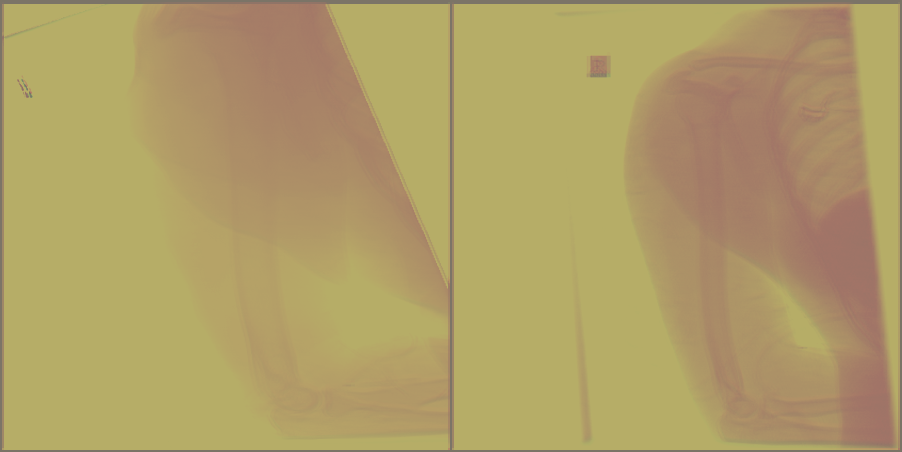

In [20]:
imgs = Image.fromarray(imgs, mode='RGB')
imgs

In [ ]:
save_path = os.path.join(model_path, model_name)

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR
import shutil
import time
from config import num_classes, model_name, model_path, lr_milestones, lr_decay_rate, input_size, \
    root, end_epoch, save_interval, init_lr, batch_size, CUDA_VISIBLE_DEVICES, weight_decay, \
    proposalN, set, channels
# from utils.train_model import train
from utils.read_dataset import read_dataset
from utils.auto_laod_resume import auto_load_resume
# from networks.model import MainNet

In [ ]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
def test_model(model, dataloaders, device):
    CM=0
    model.eval()
    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images) #file_name
            preds = torch.argmax(outputs.data, 1)
            CM + = confusion_matrix(labels.cpu(), preds.cpu(),labels=[0,1])
            
        tn=CM[0][0]
        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        sensitivity=tp/(tp+fn)
        precision=tp/(tp+fp)
        
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        print()
        print('Confusion Matirx : ')
        print(CM)
        print('- Sensitivity : ',(tp/(tp+fn))*100)
        print('- Specificity : ',(tn/(tn+fp))*100)
        print('- Precision: ',(tp/(tp+fp))*100)
        print('- NPV: ',(tn/(tn+fn))*100)
        print('- F1 : ',((2*sensitivity*precision)/(sensitivity+precision))*100)
        print()
                
    return acc, CM

In [ ]:
model = MainNet(proposalN=proposalN, num_classes=num_classes, channels=2048, theta=(0.6), red_p=0.15)

In [ ]:
model_name='one'

In [ ]:
trainloader, testloader = read_dataset(input_size, batch_size, root, set)

In [ ]:
save_path = os.path.join(model_path, model_name)
if os.path.exists(save_path):
    start_epoch, lr = auto_load_resume(model, save_path, status='train')

In [ ]:
dataset_sizes = {['train', 'test'][x]: [len(trainloader.dataset),len(testloader.dataset)][x] for x in range(len(['train', 'val']))}
dataloaders = {['train', 'test'][x]: [trainloader,testloader][x] for x in range(len(['train', 'val']))}

In [ ]:
dataset_sizes

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#coding=utf-8
import torch
import torch.nn as nn
import sys
from tqdm import tqdm
from config import input_size, root, proposalN, channels
from utils.read_dataset import read_dataset
from utils.auto_laod_resume import auto_load_resume

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if CUDA else "cpu")

#load dataset
_, testloader = read_dataset(input_size, batch_size, root, set)


model = MainNet(proposalN=proposalN, num_classes=num_classes, channels=2048, theta=(0.6), red_p=0.15)

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()


if os.path.exists(save_path):
    epoch = auto_load_resume(model, save_path, status='train')
else:
    sys.exit('There is not a pth exist.')

print('Testing')
raw_correct = 0
object_correct = 0
model.eval()
with torch.no_grad():
    for i, data in enumerate(tqdm(testloader)):
        if set == 'CUB':
            x, y, boxes, _ = data
        else:
            x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        local_logits, local_imgs = model(x, epoch, i, 'train', DEVICE)[-3:-1]
        # local
        pred = local_logits.max(1, keepdim=True)[1]
        object_correct += pred.eq(y.view_as(pred)).sum().item()

    print('\nObject branch accuracy: {}/{} ({:.2f}%)\n'.format(
            object_correct, len(testloader.dataset), 100. * object_correct / len(testloader.dataset)))